# Geospatial Elasticsearch with Python

In [1]:
%matplotlib inline

In [14]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyproj
import shapely.geometry
import geopandas as gpd

from dotenv import load_dotenv
from elasticsearch import Elasticsearch

load_dotenv(".env");

In [3]:
#filepath = '/home/hadoop/sgds/data/naturalearth/ne_10m_admin_0_countries.shp'
filepath = '/home/hadoop/sgds/data/naturalearth/ne_110m_admin_0_countries.shp'

gdf_ne = gpd.read_file(filepath)

In [4]:
es = Elasticsearch(hosts=['http://{}:{}@{}:{}'.format(
    os.environ["ES_USERNAME"],
    os.environ["ES_PASSWORD"],
    os.environ["ES_HOST"],
    os.environ["ES_PORT"],
)])

In [17]:
es.indices.get_alias()

{'gdelt_custom_20200101': {'aliases': {}},
 '.kibana-event-log-7.8.0-000001': {'aliases': {'.kibana-event-log-7.8.0': {'is_write_index': False}}},
 'ilm-history-2-000002': {'aliases': {'ilm-history-2': {'is_write_index': False,
    'is_hidden': True}}},
 '.apm-agent-configuration': {'aliases': {}},
 'kibana_sample_data_flights': {'aliases': {}},
 'kibana_sample_data_ecommerce': {'aliases': {}},
 'ilm-history-2-000003': {'aliases': {'ilm-history-2': {'is_write_index': True,
    'is_hidden': True}}},
 '.apm-custom-link': {'aliases': {}},
 '.kibana_1': {'aliases': {'.kibana': {}}},
 '.async-search': {'aliases': {}},
 'shapes': {'aliases': {}},
 '.kibana-event-log-7.8.0-000002': {'aliases': {'.kibana-event-log-7.8.0': {'is_write_index': False}}},
 '.security-7': {'aliases': {'.security': {}}},
 'ne_countries': {'aliases': {}},
 'ilm-history-2-000001': {'aliases': {'ilm-history-2': {'is_write_index': False,
    'is_hidden': True}}},
 '.kibana-event-log-7.8.0-000003': {'aliases': {'.kibana-e

In [10]:
es.count(index='gdelt_custom_2020')

{'count': 24330238,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}

# Bounding Box Query

- [Geo-bounding box query](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-geo-bounding-box-query.html)

In [11]:
EXTENT = [-126.6,23.1,-64.4,49.3]

result = es.search(index='gdelt_custom_2020', body={
    "size": 10000,
    "query": {
        "bool" : {
            "must" : {
                "match_all" : {}
            },
            "filter" : {
                "geo_bounding_box" : {
                    "location" : {
                        "top_left" : [EXTENT[0], EXTENT[3]],
                        "bottom_right" : [EXTENT[2], EXTENT[1]]
                    }
                }
            }
        }
    }
})

print('total', result['hits']['total']['value'])

total 10000


In [12]:
df = pd.DataFrame(d['_source'] for d in result['hits']['hits'])
df['geom'] = df.apply(lambda row: 
    shapely.geometry.Point(row['lon'], row['lat']), axis=1)
df.drop(columns=['lon', 'lat', 'message', '@version', 'location'], 
        inplace=True)
gdf = gpd.GeoDataFrame(df, geometry='geom', crs='epsg:4326')
gdf.head()

,event_id,event_base_code,source_url,@timestamp,event_date,event_code,host,event_root_code,date,geom
0,897471043,20,https://abc13.com/politics/community-and-mayor...,2020-09-19T13:02:05.919Z,2020-01-07T23:00:00.000Z,20,node-master,2,2020-01-07T23:00:00.000Z,POINT (-95.36330 29.76330)
1,897471044,36,https://tdn.com/news/local/no-perfect-site-for...,2020-09-19T13:02:05.919Z,2020-01-07T23:00:00.000Z,36,node-master,3,2020-01-07T23:00:00.000Z,POINT (-122.12700 44.56720)
2,897471045,40,https://wspd.iheart.com/featured/scott-sands/c...,2020-09-19T13:02:05.919Z,2020-01-07T23:00:00.000Z,40,node-master,4,2020-01-07T23:00:00.000Z,POINT (-77.03640 38.89510)
3,897471046,40,https://www.thv11.com/article/news/nation-worl...,2020-09-19T13:02:05.919Z,2020-01-07T23:00:00.000Z,40,node-master,4,2020-01-07T23:00:00.000Z,POINT (-81.71700 27.83330)
4,897471080,195,https://www.dailyitem.com/region/the-latest-au...,2020-09-19T13:02:05.919Z,2020-01-07T23:00:00.000Z,195,node-master,19,2020-01-07T23:00:00.000Z,POINT (-74.93840 42.14970)


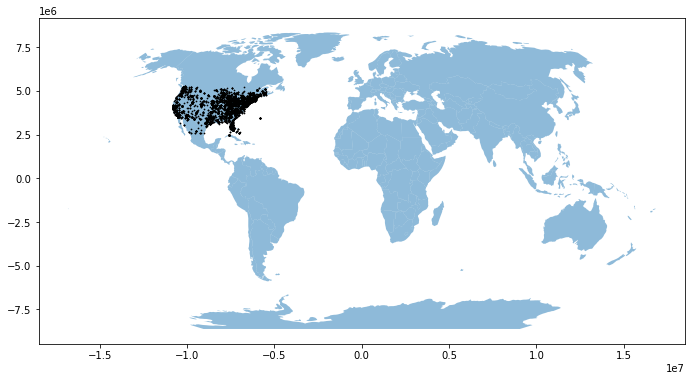

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

gdf_ne.to_crs({'proj': 'robin'}).plot(ax=ax, alpha=0.5)
gdf.to_crs({'proj': 'robin'}).plot(ax=ax, c='k', markersize=0.5);

# Sorting by Distance

In [24]:
%%time
lat, lon = 48.864716, 2.349014

result = es.search(index='gdelt_custom_20200101', body={
    "size": 10000,
    "sort" : [
        {
            "_geo_distance" : {
                "location" : {
                    "lon": lon, "lat": lat
                },
                "order" : "asc",
                "unit" : "km"
            }
        }
    ]
})

print('total', result['hits']['total']['value'])

total 10000
CPU times: user 113 ms, sys: 59.5 ms, total: 172 ms
Wall time: 1.2 s


In [25]:
df = pd.DataFrame(d['_source'] for d in result['hits']['hits'])
df['geom'] = df.apply(lambda row: 
    shapely.geometry.Point(row['lon'], row['lat']), axis=1)
df.drop(columns=['lon', 'lat', 'message', '@version', 'location'], inplace=True)
gdf = gpd.GeoDataFrame(df, geometry='geom', crs='epsg:4326')
gdf.head()

,event_root_code,event_id,host,source_url,event_date,date,event_base_code,event_code,@timestamp,geom
0,2,896070490,node-master,https://www.euronews.com/2020/01/01/macron-say...,2019-12-31T23:00:00.000Z,1919-12-31T23:00:00.000Z,25,256,2020-09-19T12:28:14.491Z,POINT (2.33333 48.86670)
1,3,896072291,node-master,https://www.nbcnews.com/news/us-news/biggest-s...,2019-12-31T23:00:00.000Z,1919-12-31T23:00:00.000Z,30,30,2020-09-19T12:28:15.280Z,POINT (2.33333 48.86670)
2,4,896074099,node-master,http://yourblackworld.net/2019/12/31/three-fre...,2019-12-31T23:00:00.000Z,1919-12-31T23:00:00.000Z,41,41,2020-09-19T12:28:15.601Z,POINT (2.33333 48.86670)
3,2,896061517,node-master,https://www.jpost.com/Diaspora/Insanity-defens...,2019-12-31T23:00:00.000Z,1919-12-31T23:00:00.000Z,20,20,2020-09-19T12:28:11.629Z,POINT (2.33333 48.86670)
4,4,896062854,node-master,https://www.globalsecurity.org/wmd/library/new...,2019-12-31T23:00:00.000Z,1919-12-31T23:00:00.000Z,46,46,2020-09-19T12:28:12.199Z,POINT (2.33333 48.86670)


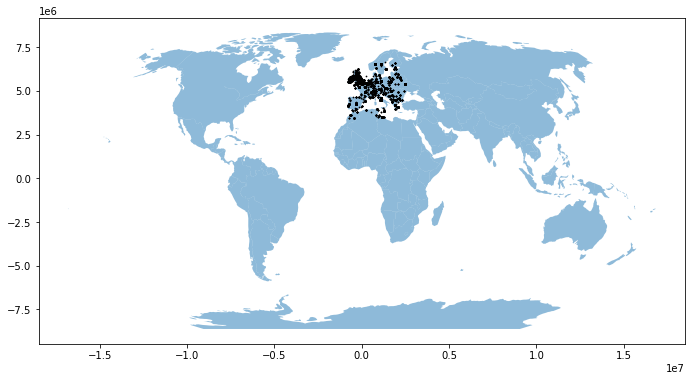

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))

gdf_ne.to_crs({'proj': 'robin'}).plot(ax=ax, alpha=0.5)
gdf.to_crs({'proj': 'robin'}).plot(ax=ax, c='k', markersize=0.5);